<a href="https://colab.research.google.com/github/Ch4rlesSm1th99/Fine-Tuning-RNN-s/blob/main/Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models,transforms
from torchvision.utils import make_grid
from torchvision.datasets import MNIST
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary


In [15]:
# MNIST
def mnist(batch_sz, valid_size=0.2, shuffle=True, random_seed=2000):
    num_classes = 10
    transform_train = transforms.Compose([
                        transforms.RandomCrop(28, padding=4),
                        transforms.ToTensor(),
                    ])

    transform_valid = transforms.Compose([
                        transforms.ToTensor(),
                    ])

    transform_test = transforms.Compose([
                        transforms.ToTensor(),
                    ])


    # Training dataset
    train_data = MNIST(root='./datasets', train=True, download=True, transform=transform_train)
    valid_data = MNIST(root='./datasets', train=True, download=True, transform=transform_valid)
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    if shuffle == True:
        np.random.seed(random_seed)
        np.random.shuffle(indices)
    train_idx, valid_idx = indices[split:], indices[:split]

    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_sz, sampler=train_sampler,pin_memory=True)
    valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_sz, sampler=valid_sampler,pin_memory=True)

    # Test dataset
    test_data = MNIST(root='./datasets', train=False, download=True, transform=transform_test)
    test_loader = torch.utils.data.DataLoader(test_data,
                                              batch_size=batch_sz, shuffle=False, pin_memory=True)

    return train_loader, valid_loader, test_loader



In [16]:
batch_sz=64 # this is batch size i.e. the number of rows in a batch of data
train_loader, valid_loader, test_loader=mnist(batch_sz)

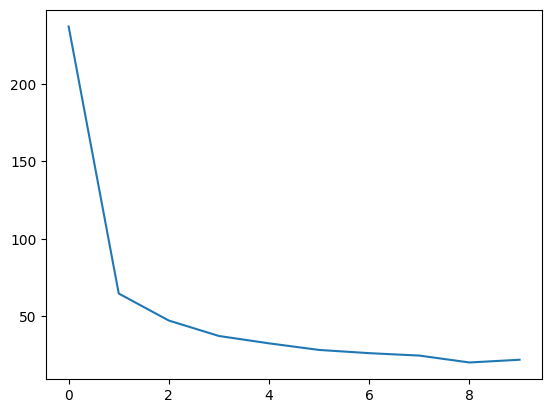

In [17]:
device = torch.device("cuda:0")
net = models.resnet18(num_classes = 10)
net.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

net =net.to(device)

lr = 0.1
momentum = 0.5
num_epochs = 10

opt = optim.SGD(net.parameters(), lr = lr, momentum = momentum)
ls = []
for i in range(num_epochs):
  total_loss = 0
  for batch in train_loader:
    X, y = batch[0].to(device), batch[1].to(device)
    logits = net(X)
    loss = F.cross_entropy(logits, y)
    opt.zero_grad()
    loss.backward()
    opt.step()
    total_loss+=loss.item()

  ls.append(total_loss)


plt.plot(ls)



Fine Tuning Begins Here

In [18]:
# load the pre-trained ResNet-18 model
# load the pre-trained model on the ImageNet dataset
net = models.resnet18(pretrained=True)
print(net)

# freeze the entire network (backbone) to prevent weights from being updated during training
# fhis is done because we want to use the learned features from ImageNet without altering them opposed to initial guesses
for params in net.parameters():
    params.requires_grad = False

# replace the first convolutional layer of ResNet-18
# Thus, we change the input channels from 3 to 1 and keep other parameters the same
net.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

# Replace the fully connected layer (fc) of ResNet-18
# We change it to output 10 classes, corresponding to the 10 digits in MNIST opposed to the 1000 class imagenet
net.fc = nn.Linear(in_features=512, out_features=10, bias=True)

for name, params in net.named_parameters():
    print(name, params.requires_grad)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

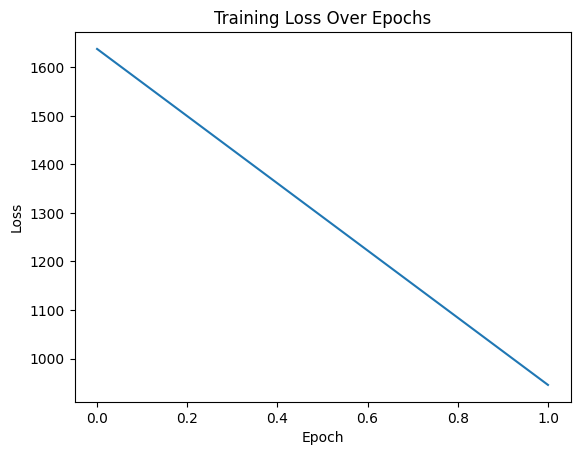

In [19]:

# traininign the classifier
# in this specific case due to channel mismatch (3 to 1) of the data sets we must also train the first layer
device = torch.device("cuda:0")
net = net.to(device)

lr = 0.1
momentum = 0.5
num_epochs = 2

opt = torch.optim.SGD(net.parameters(), lr=lr, momentum=momentum)
ls = []

# training loop
for i in range(num_epochs):
    total_loss = 0
    for batch in train_loader:
        X, y = batch[0].to(device), batch[1].to(device)
        # Forward pass
        logits = net(X)
        loss = F.cross_entropy(logits, y)
        opt.zero_grad()
        # Backward pass
        loss.backward()
        opt.step()
        total_loss += loss.item()
    ls.append(total_loss)

plt.plot(ls)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()

In [20]:
summary(net, X.shape[1:],)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           3,136
       BatchNorm2d-2           [-1, 64, 14, 14]             128
              ReLU-3           [-1, 64, 14, 14]               0
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Conv2d-5             [-1, 64, 7, 7]          36,864
       BatchNorm2d-6             [-1, 64, 7, 7]             128
              ReLU-7             [-1, 64, 7, 7]               0
            Conv2d-8             [-1, 64, 7, 7]          36,864
       BatchNorm2d-9             [-1, 64, 7, 7]             128
             ReLU-10             [-1, 64, 7, 7]               0
       BasicBlock-11             [-1, 64, 7, 7]               0
           Conv2d-12             [-1, 64, 7, 7]          36,864
      BatchNorm2d-13             [-1, 64, 7, 7]             128
             ReLU-14             [-1, 6

In [21]:
#unfreezing
for params in net.parameters():
  params.requires_grad = True

In [22]:
#fine tuning full network
device = torch.device("cuda:0")
net = net.to(device)

lr = 0.01
momentum = 0.5
num_epochs = 5

opt = torch.optim.SGD(net.parameters() , lr = lr, momentum = momentum)
ls = []
for i in range(num_epochs):
  total_loss = 0
  for batch in train_loader:
    X, y = batch[0].to(device), batch[1].to(device)
    logits = net(X)
    loss = F.cross_entropy(logits, y)
    opt.zero_grad()
    loss.backward()
    opt.step()
    total_loss+=loss.item()

  ls.append(total_loss/len(train_loader))

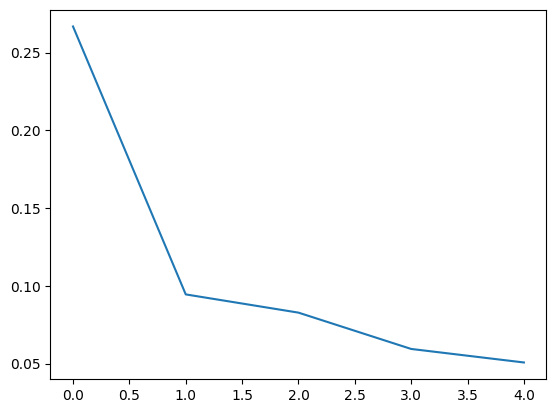

In [23]:
plt.plot(ls)